Here, we want to know the model with the best explanatory power, compared to the rest.

## Requirements

```bash

mamba create -n acnets_bambi
mamba activate acnets_bambi
mamba install bambi ipykernel seaborn watermark
```

In [41]:
import bambi
import arviz as az
import xarray as xr
import re
import pandas as pd
import matplotlib.pyplot as plt

In [42]:
INPUT_MODEL_NAME = 'connectivities_classifier-SVML1_measure-accuracy_top-6_cv-100x4fold'
OUTPUT_MODEL_NAME = f'{INPUT_MODEL_NAME}_bambi-1000draws'

In [43]:
results = xr.open_dataset(f'models/{INPUT_MODEL_NAME}.nc').load()

split_score_cols = [c for c in list(results.keys()) if re.match(r'split\d+_test_score', c)]
grid_cv_results = results[split_score_cols + ['rank_test_score', 'mean_test_score']].to_pandas()
grid_cv_results.index.name = 'label'
grid_cv_results = grid_cv_results.reset_index()

scores = grid_cv_results
# scores['label'] = scores['params'].apply(lambda p: _create_label(list(p.values())))
split_score_cols = [c for c in scores.columns if 'split' in c]
scores['test_score'] = scores[split_score_cols].apply(lambda x: list(x), axis=1)
scores = scores.explode('test_score').reset_index(drop=True)
scores = scores.sort_values('rank_test_score', ascending=False)
scores['label'] = scores['label'].apply(lambda x: x.replace('partial correlation', 'partial_correlation'))

scores[['atlas','kind']] = scores['label'].apply(lambda x: x.split(' ')).apply(pd.Series)
scores = scores[['atlas', 'kind', 'test_score']]

In [44]:
model = bambi.Model('test_score ~ 0 + atlas * kind', scores)
fitted = model.fit(tune=500, draws=1000, init='adapt_diag')

fitted.to_netcdf(f'outputs/model_comparison/{OUTPUT_MODEL_NAME}.nc')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [atlas, kind, atlas:kind, test_score_sigma]


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 32 seconds.


'outputs/model_comparisonconnectivities_classifier-SVML1_measure-accuracy_top-6_cv-100x4fold_bambi-1000draws.nc'

## Part 2: Visualization

In [49]:
fitted = az.data.inference_data.InferenceData.from_netcdf(f'outputs/model_comparison/{OUTPUT_MODEL_NAME}.nc')

az.summary(fitted).sort_values('mean', ascending=False)

# DEBUG plot using arviz
# az.plot_trace(fitted, legend=True)
# plt.tight_layout()
# plt.show()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
atlas[dosenbach2010],3.754,0.125,3.514,3.984,0.002,0.001,3747.0,2871.0,1.0
atlas[gordon2014_2mm],2.999,0.128,2.769,3.250,0.002,0.001,4431.0,2899.0,1.0
atlas[seitzman2018],2.918,0.130,2.666,3.157,0.002,0.002,3554.0,2525.0,1.0
atlas[difumo_64_2mm],2.759,0.129,2.508,2.995,0.003,0.002,1492.0,2205.0,1.0
"atlas:kind[seitzman2018, covariance]",1.330,0.259,0.844,1.823,0.006,0.004,2160.0,2811.0,1.0
test_score_sigma,1.279,0.021,1.241,1.316,0.000,0.000,5894.0,2640.0,1.0
"atlas:kind[gordon2014_2mm, tangent]",1.039,0.253,0.555,1.506,0.006,0.004,2123.0,2864.0,1.0
kind[precision],0.822,0.183,0.495,1.164,0.004,0.003,1771.0,2414.0,1.0
"atlas:kind[gordon2014_2mm, partial_correlation]",0.818,0.254,0.340,1.290,0.005,0.004,2360.0,2886.0,1.0
"atlas:kind[dosenbach2010, partial_correlation]",0.797,0.257,0.289,1.258,0.006,0.004,2124.0,2681.0,1.0


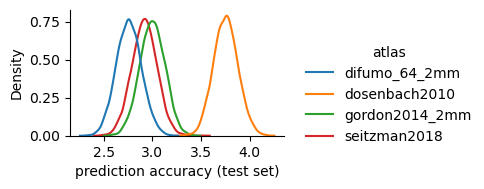

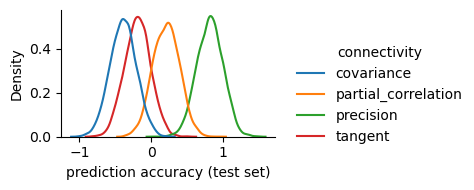

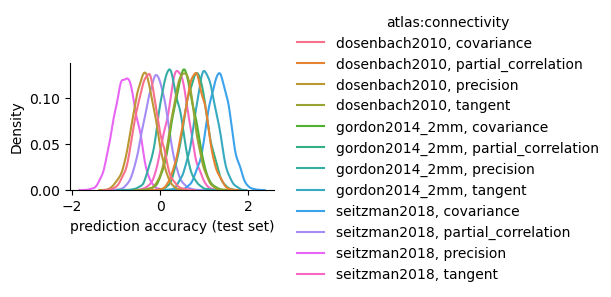

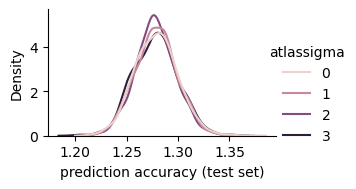

In [50]:
# Plot posteriors

import seaborn as sns

for i, var_name in enumerate(fitted['posterior'].data_vars):
    plot_data = fitted['posterior'][var_name].to_dataframe().reset_index()
    hue_dim = 0 if 'test_score_sigma' in var_name else 2
    g = sns.displot(data=plot_data,
                    x=var_name,
                    kind='kde',
                    aspect=1.5,
                    height=2,
                    hue=fitted['posterior'][var_name].dims[hue_dim],
                    # height=2, aspect=2,
                    )
    g.set(xlabel='prediction accuracy (test set)')
    title = var_name
    title = title.replace('kind', 'connectivity')
    title = title.replace('test_score_', 'atlas')
    # g.set(title=title)
    # g.legend.set_title(g.legend.get_title().get_text().replace('_dim',''))
    g.legend.set_title(title)
    plt.show()


In [52]:
%reload_ext watermark
%watermark -n -u -v -iv -w

Last updated: Wed Nov 30 2022

Python implementation: CPython
Python version       : 3.10.8
IPython version      : 8.6.0

matplotlib       : 3.6.2
arviz            : 0.14.0
seaborn          : 0.12.1
matplotlib_inline: 0.1.6
bambi            : 0.9.1
pandas           : 1.5.2
re               : 2.2.1
sys              : 3.10.8 | packaged by conda-forge | (main, Nov 22 2022, 08:26:04) [GCC 10.4.0]
xarray           : 2022.11.0

Watermark: 2.3.1

